In [28]:
# All imported libraries
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
from keras.layers import Dense, Flatten
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
import time
import math

## Dataset inladen
Deze functie laadt en verwerkt een dataset die bestaat uit trainings- en testafbeeldingen, waarbij elke afbeelding wordt vergezeld door een XML-bestand dat de begrenzende dooscoördinaten van een object in de afbeelding bevat. De afbeeldingen worden omgezet van het BGR-kleurformaat naar RGB, vervolgens geresized en genormaliseerd naar een bereik van 0 tot 1. De begrenzende dooscoördinaten worden geëxtraheerd uit de bijbehorende XML-bestanden en geschaald om overeen te komen met de aangepaste afbeeldingsgrootte. De resulterende gegevens worden opgeslagen als numpy-arrays en geretourneerd als vier sets: trainingsafbeeldingen, trainingsbegrenzende dozen, testafbeeldingen en testbegrenzende dozen. Eventuele fouten tijdens het laden of verwerken worden afgedrukt naar de console.

In [29]:
def loadDataSet(dataset_path='dataset', img_size=(224, 224)):
    dataset_splits = ['train', 'test']
    data_dict = {dataset_split: {'x': [], 'y': []} for dataset_split in dataset_splits}
    img_shape = None

    for dataset_split in dataset_splits:
        split_path = os.path.join(dataset_path, dataset_split)
        data = os.listdir(split_path)

        for item in data:
            if item.endswith('.jpg'):
                # Load the image
                img = cv2.imread(os.path.join(split_path, item))
                if img is not None:
                    img_shape = img.shape  # Update img_shape with the current image shape

                    # Convert from BGR to RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # Resize and normalize the image
                    img = cv2.resize(img, img_size)
                    img = img.astype('float32') / 255.0  # Normalize to [0, 1]
                    data_dict[dataset_split]['x'].append(img)

                    # Load corresponding XML file
                    xml_file_path = os.path.join(split_path, item.replace('.jpg', '.xml'))
                    try:
                        tree = ET.parse(xml_file_path)
                        root = tree.getroot()

                        # Extract bounding box information from XML
                        xmin = int(root.find('.//xmin').text)
                        ymin = int(root.find('.//ymin').text)
                        xmax = int(root.find('.//xmax').text)
                        ymax = int(root.find('.//ymax').text)

                        # Scale the bounding box coordinates to match the resized image
                        scale_x = img_size[0] / img_shape[1]
                        scale_y = img_size[1] / img_shape[0]
                        xmin = int(xmin * scale_x)
                        ymin = int(ymin * scale_y)
                        xmax = int(xmax * scale_x)
                        ymax = int(ymax * scale_y)

                        data_dict[dataset_split]['y'].append([xmin, ymin, xmax, ymax])
                    except Exception as e:
                        print(f"Error processing XML file {xml_file_path}: {e}")

                else:
                    print(f"Error loading image: {os.path.join(split_path, item)}")

    # Convert lists to numpy arrays
    for dataset_split in dataset_splits:
        data_dict[dataset_split]['x'] = np.array(data_dict[dataset_split]['x'])
        data_dict[dataset_split]['y'] = np.array(data_dict[dataset_split]['y'])

    return (
        data_dict['train']['x'],
        data_dict['train']['y'],
        data_dict['test']['x'],
        data_dict['test']['y']
)

X_train, Y_train, X_test, Y_test = loadDataSet()

## Neural network
In the following code I make a model based on the VGG16 model from Keras. For detecting cars in images, the VGG16 model can be fine-tuned on a dataset of car images, where the last fully connected layer is replaced with a new output layer that predicts the bounding box coordinates of the car in the image. The pre-trained weights of the model can then be fine-tuned on this new task, which allows the model to learn to detect cars in images with high accuracy.

To fine-tune the VGG16 model I dont include the top classification layer and make it myself. 
These lines add a flatten layer and a dense layer on top of the pre-trained VGG16 model. The Flatten layer flattens the output from the previous layer to a 1D tensor. The first Dense layer has 256 units with a ReLU activation function. The final Dense layer has 4 units with a linear activation function.

In [30]:
# Get the input shape from X_train
input_shape = X_train.shape[1:]

# Load VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a flatten layer and a dense layer for classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(4, activation='linear')(x)

# Create a new model with input and output layers, so that only the weights of the new top classification layer will be updated during training.
model = Model(inputs=base_model.input, outputs=output)

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Training the Model
The model is being trained below, I am using 10 epochs because it does not find much improvement after that.

In [31]:
# Train the model
hist = model.fit(X_train, Y_train, epochs=12, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/12
3/3 [==============================] - 10s 3s/step - loss: 17461.1992 - mean_squared_error: 17461.1992 - val_loss: 10563.6387 - val_mean_squared_error: 10563.6387
Epoch 2/12
3/3 [==============================] - 9s 3s/step - loss: 7778.5000 - mean_squared_error: 7778.5000 - val_loss: 3042.8364 - val_mean_squared_error: 3042.8364
Epoch 3/12
3/3 [==============================] - 9s 3s/step - loss: 2086.0090 - mean_squared_error: 2086.0090 - val_loss: 782.9795 - val_mean_squared_error: 782.9795
Epoch 4/12
3/3 [==============================] - 9s 3s/step - loss: 1083.4236 - mean_squared_error: 1083.4236 - val_loss: 1938.8287 - val_mean_squared_error: 1938.8287
Epoch 5/12
3/3 [==============================] - 9s 3s/step - loss: 2123.2075 - mean_squared_error: 2123.2075 - val_loss: 2512.4565 - val_mean_squared_error: 2512.4565
Epoch 6/12
3/3 [==============================] - 9s 3s/step - loss: 2218.3806 - mean_squared_error: 2218.3806 - val_loss: 1698.9377 - val_mean_squared_

## Results training
Below are the results of training the model. As can be seen in the histogram, the algorithm quickly improves in recognizing cars. This is also evident in the orange line, which validates this.

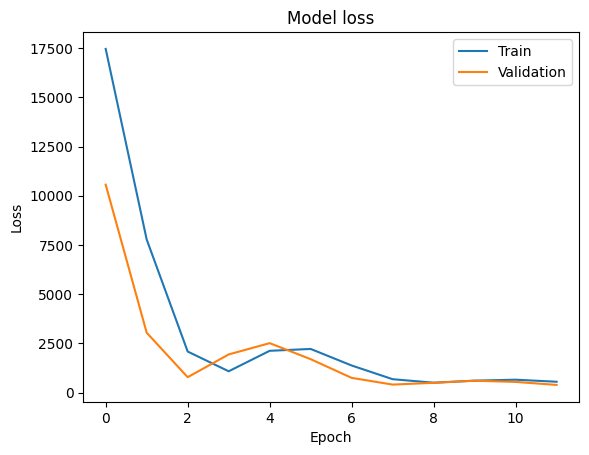

In [32]:
# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


### Model opslaan

In [33]:
# Save the model
model.save("improved_model.h5")

## Results
As can be seen in the images, my model can usually extract the car from the image. The bounding box is not always perfectly around the car, but it usually identifies the headlights. It sometimes struggles with clouds and mountains, where the model can be completely wrong.

1/1 [==============================] - 0s 159ms/step


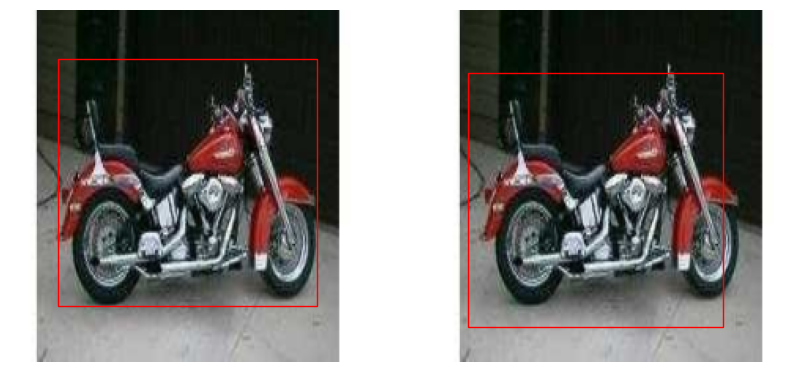

0.781847726734148
1/1 [==============================] - 0s 76ms/step


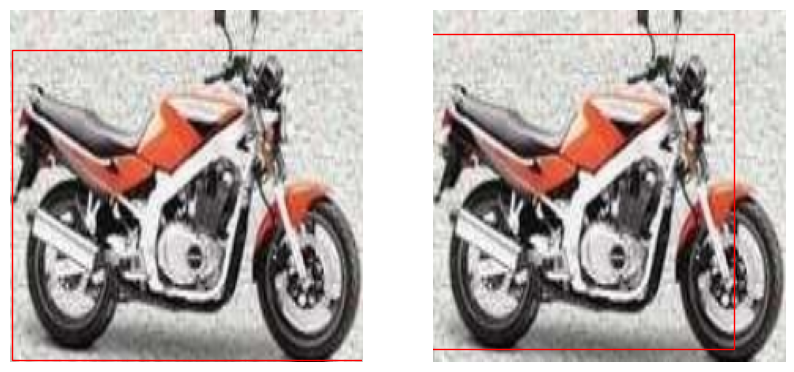

0.7751030467853652
1/1 [==============================] - 0s 67ms/step


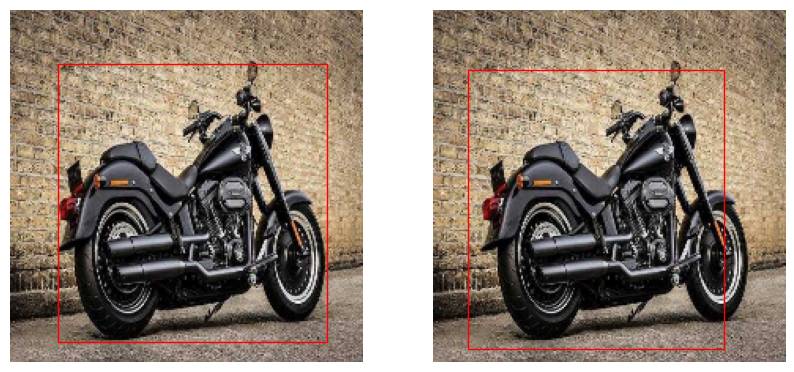

0.8310066127847171
1/1 [==============================] - 0s 69ms/step


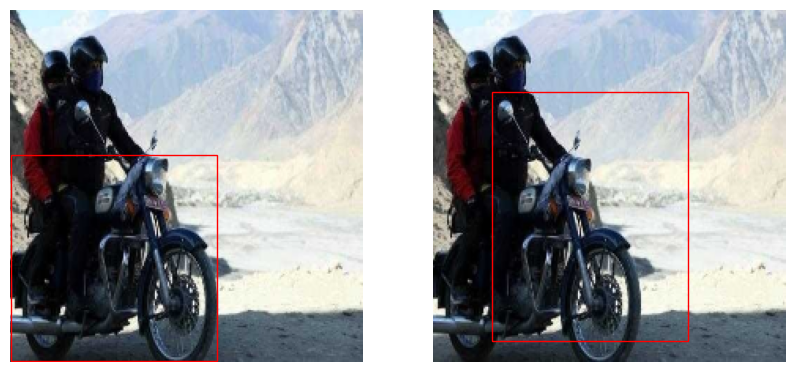

0.43226398501127977
1/1 [==============================] - 0s 78ms/step


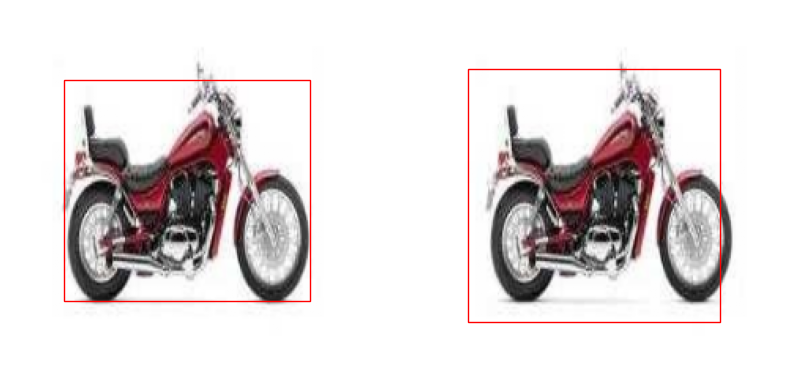

0.7773532221324124
1/1 [==============================] - 0s 80ms/step


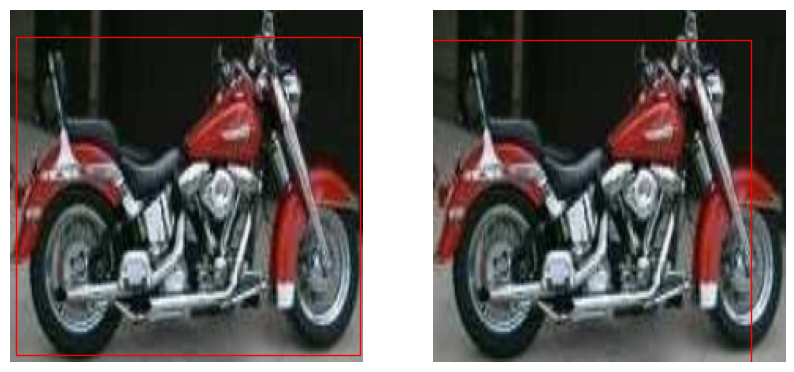

0.8314374353671148
1/1 [==============================] - 0s 79ms/step


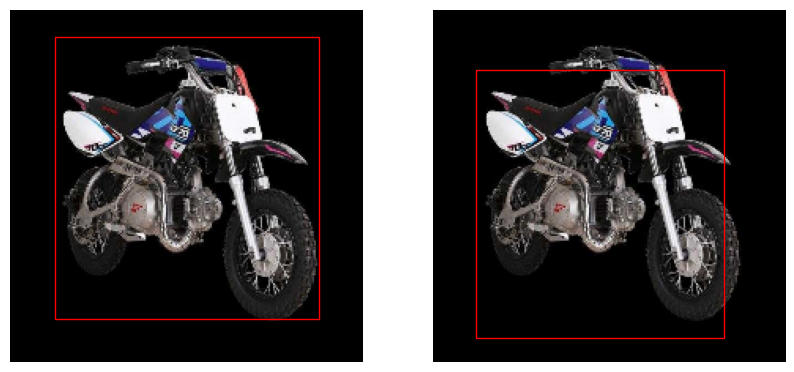

0.7732939329577985
1/1 [==============================] - 0s 74ms/step


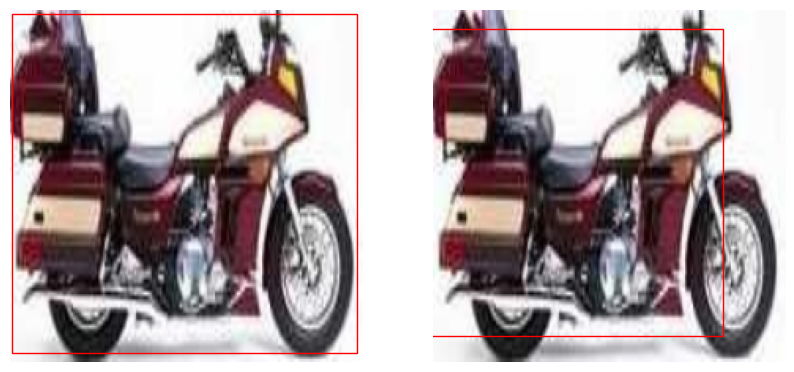

0.734321550741163
1/1 [==============================] - 0s 81ms/step


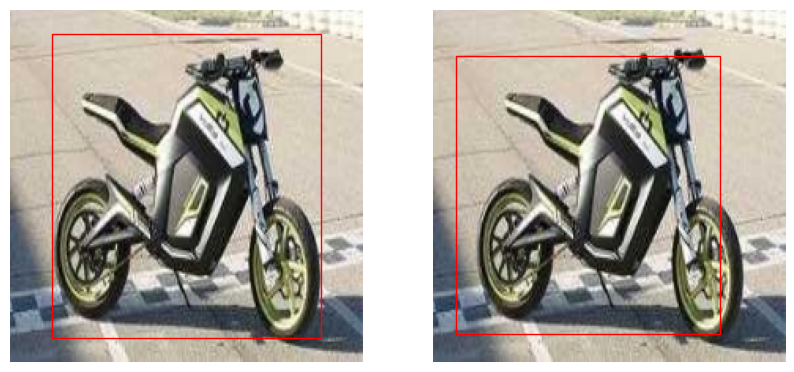

0.7871225777377197
1/1 [==============================] - 0s 72ms/step


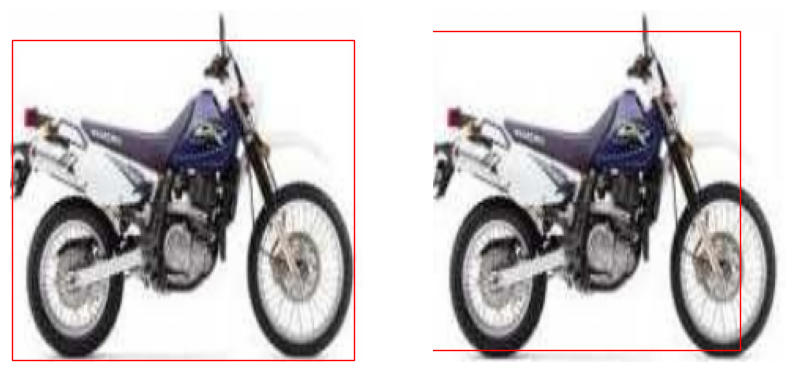

0.8202676864244742
1/1 [==============================] - 0s 74ms/step


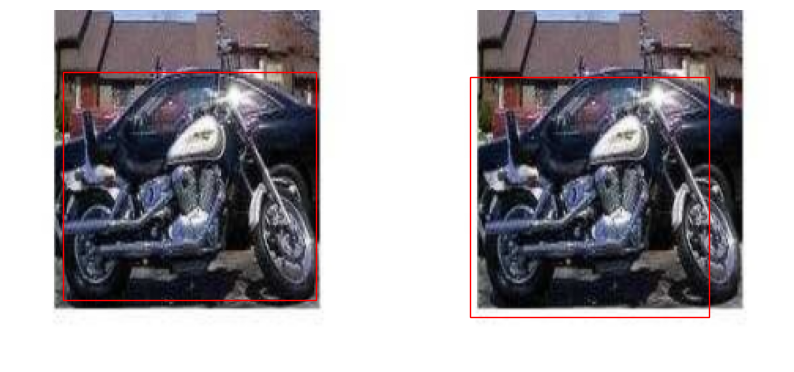

0.7640201756024659
1/1 [==============================] - 0s 73ms/step


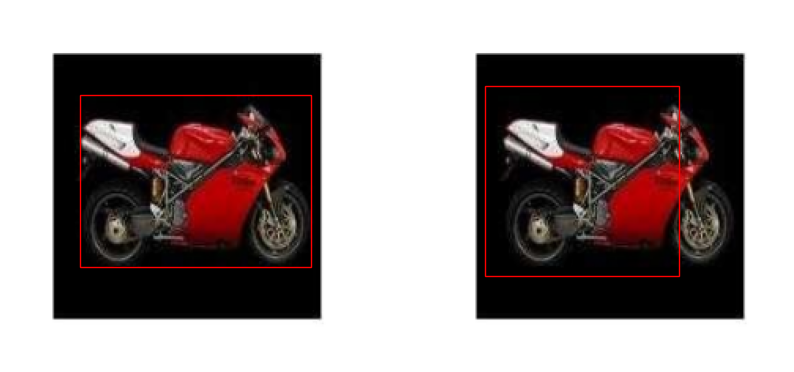

0.6549689113710613
1/1 [==============================] - 0s 76ms/step


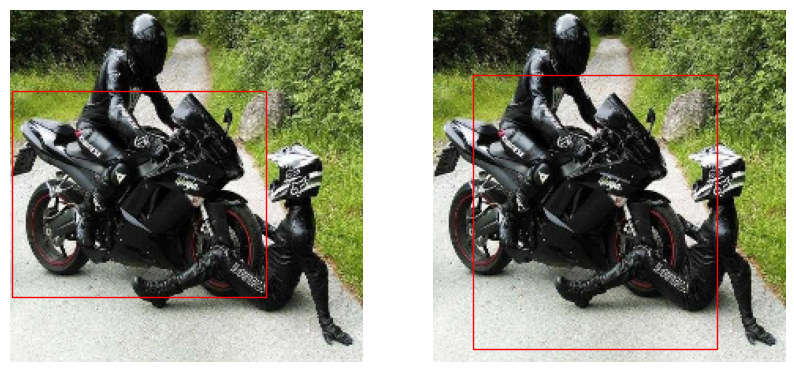

0.5978731784166995
1/1 [==============================] - 0s 88ms/step


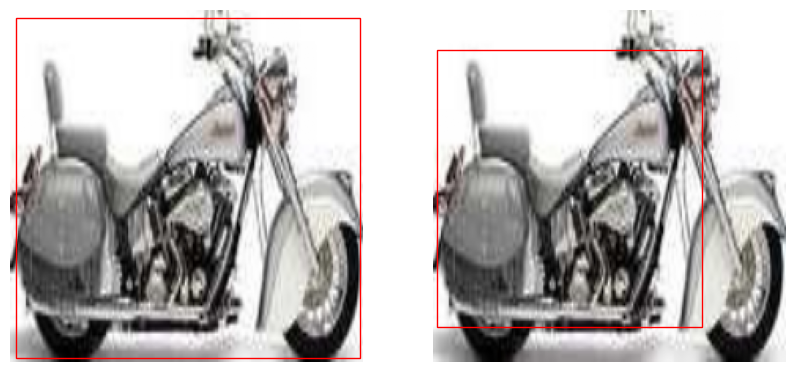

0.6242669616211366
1/1 [==============================] - 0s 85ms/step


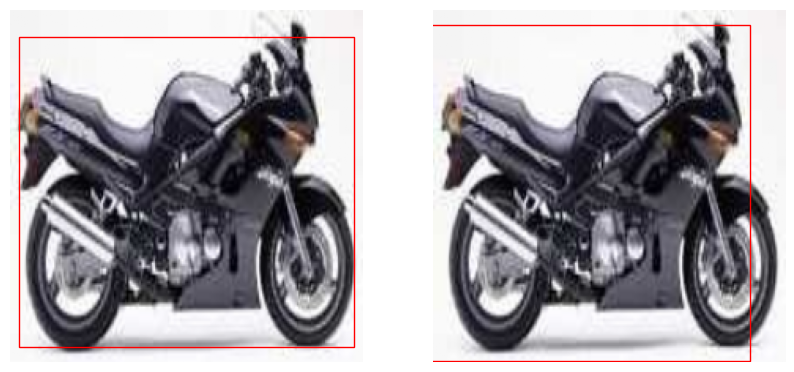

0.800435041349449
1/1 [==============================] - 0s 74ms/step


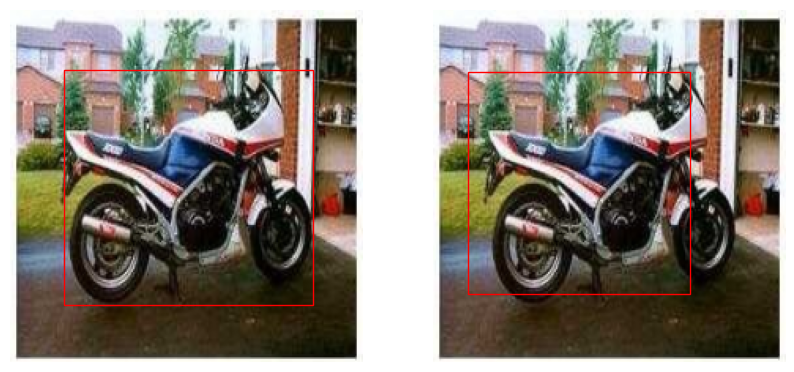

0.7223917977616029
1/1 [==============================] - 0s 77ms/step


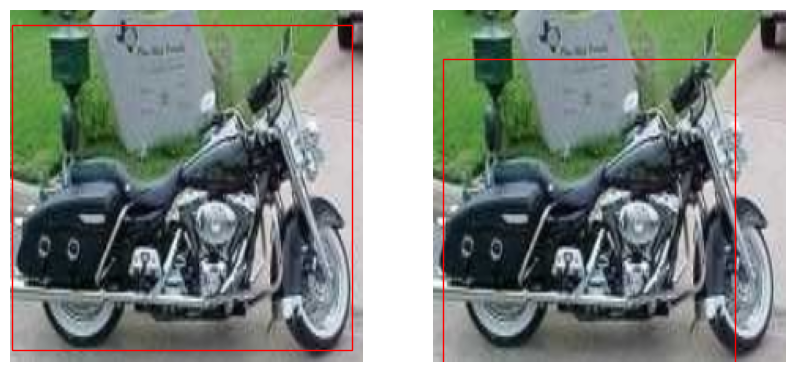

0.7458826556870818
1/1 [==============================] - 0s 72ms/step


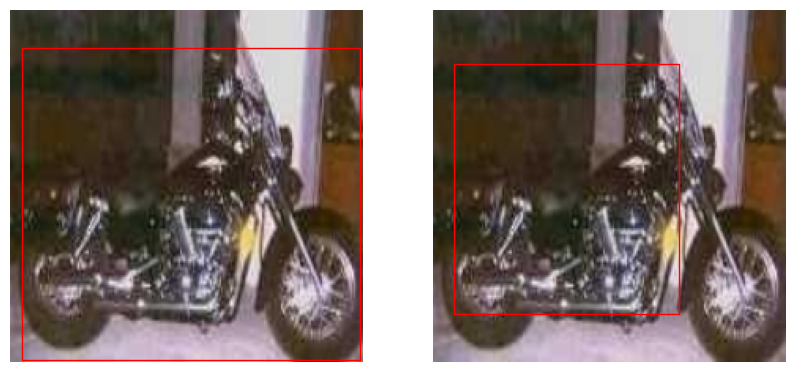

0.5360134003350083
1/1 [==============================] - 0s 74ms/step


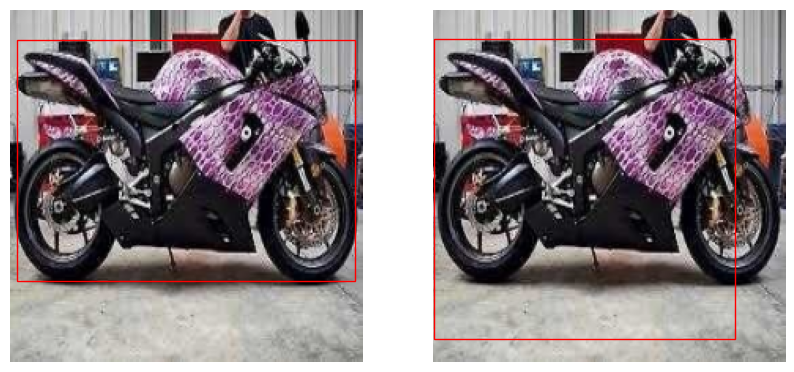

0.7062163342553501
1/1 [==============================] - 0s 83ms/step


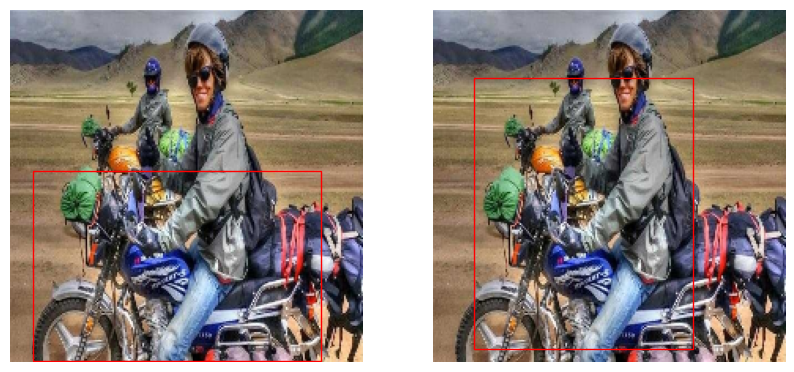

0.5197342711996874
1/1 [==============================] - 0s 74ms/step


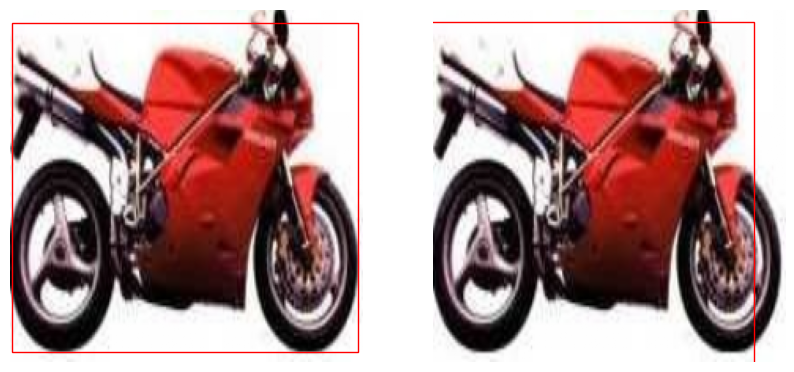

0.8384710234278668
1/1 [==============================] - 0s 85ms/step


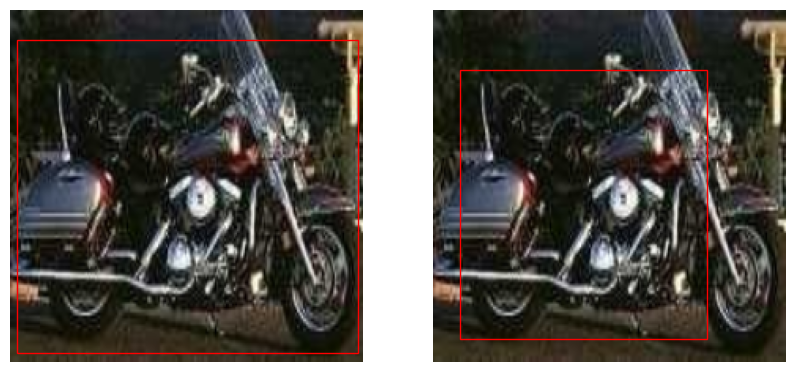

0.623302752293578
1/1 [==============================] - 0s 81ms/step


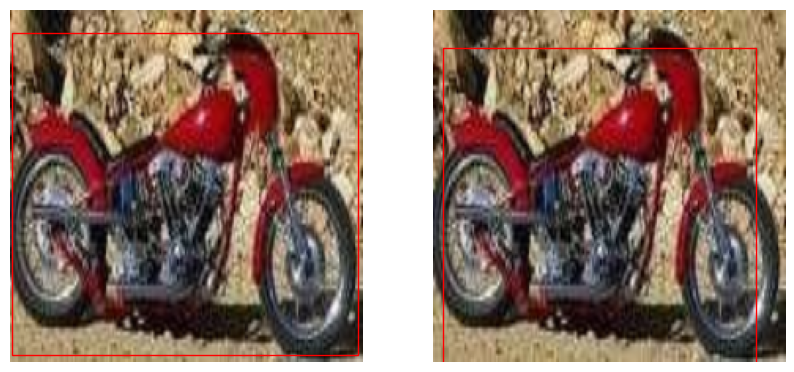

0.7883199935647347
1/1 [==============================] - 0s 91ms/step


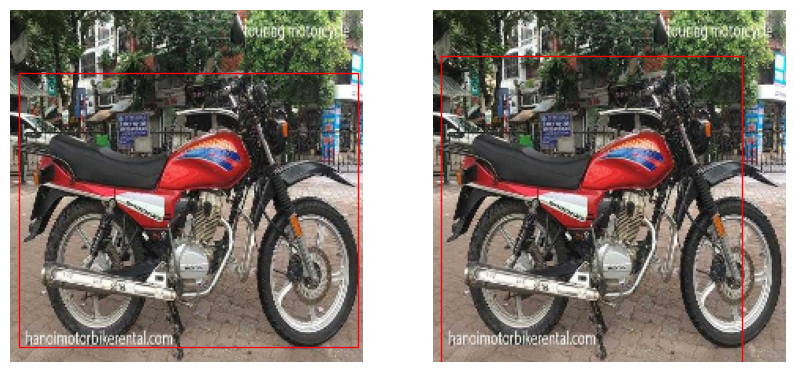

0.7926210752282324
1/1 [==============================] - 0s 86ms/step


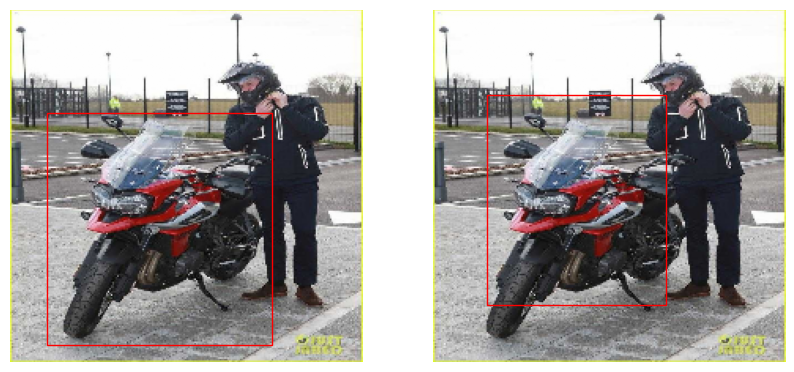

0.6225518243035078
1/1 [==============================] - 0s 97ms/step


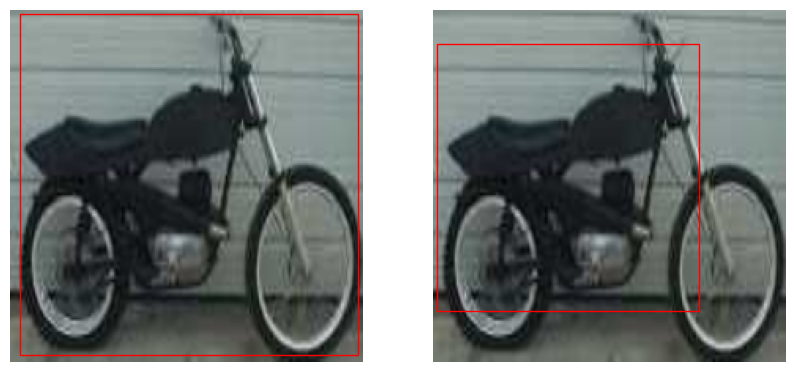

0.5870384325546345
1/1 [==============================] - 0s 89ms/step


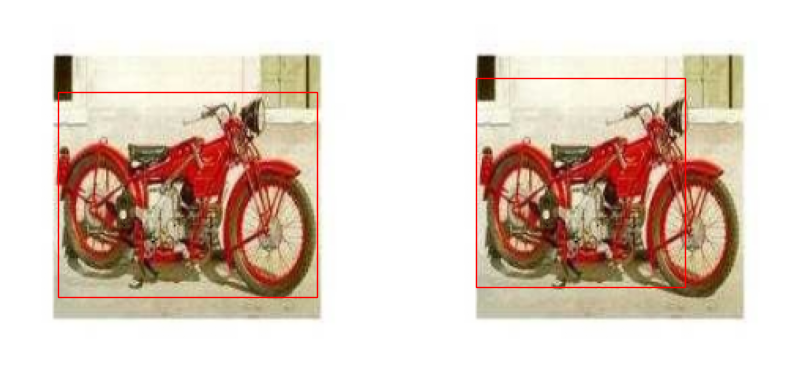

0.7019762506966176
1/1 [==============================] - 0s 98ms/step


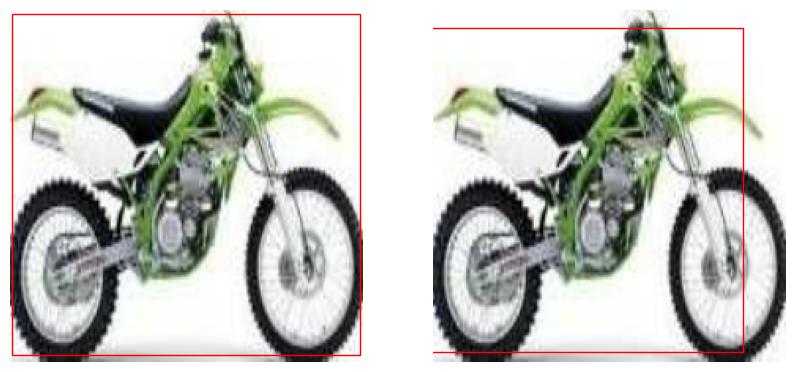

0.8147326780148645
1/1 [==============================] - 0s 87ms/step


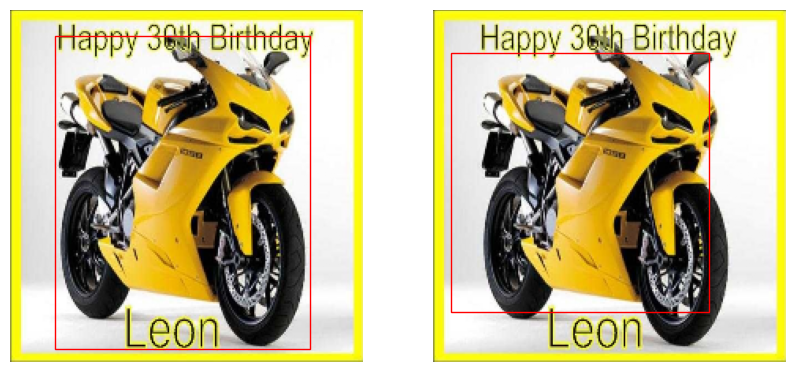

0.6935802608548359
1/1 [==============================] - 0s 89ms/step


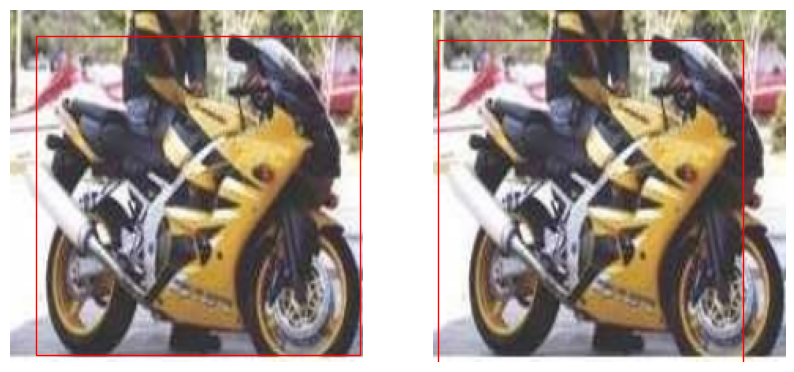

0.7753544859159407
Average IoU Score: 
0.7151256427043516


In [34]:
# Calculates the distance between two rectangles defined by their 4 corner points.
def rectangle_distance(rect1, rect2):
    # Calculate the midpoint of each rectangle
    rect1_midpoint = ((rect1[0] + rect1[2]) / 2, (rect1[1] + rect1[3]) / 2)
    rect2_midpoint = ((rect2[0] + rect2[2]) / 2, (rect2[1] + rect2[3]) / 2)

    # Calculate the distance between the midpoints
    distance = math.sqrt((rect1_midpoint[0] - rect2_midpoint[0])**2 + (rect1_midpoint[1] - rect2_midpoint[1])**2)

    return round(distance, 2)

def calculate_IoU(box1, box2):
    """
    Calculate IoU (Intersection over Union) between two bounding boxes.
    Each bounding box is represented as a tuple (x1, y1, x2, y2),
    where (x1, y1) are the coordinates of the top-left corner,
    and (x2, y2) are the coordinates of the bottom-right corner.
    """

    # Calculate intersection coordinates
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Calculate intersection area
    intersection_area = max(0, x2_inter - x1_inter + 1) * max(0, y2_inter - y1_inter + 1)

    # Calculate area of each bounding box
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    IoU = intersection_area / union_area

    return IoU


# Display one image without and one image with bounding boxes.
def display_image(path, bounding_boxes_list):
    fig, image = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))  # Specify the figure size

    for index, item in enumerate(bounding_boxes_list):
        xmin, ymin, xmax, ymax = bounding_boxes_list[index]

        # Use 'viridis' colormap to retain the original colors
        image[index].imshow(path, cmap='viridis')  
        bbox = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        image[index].add_patch(bbox)
        image[index].axis("off")

    plt.show()


score = 0
# Loop through the image filenames and process each image
for index, item in enumerate(X_test):
    image = np.expand_dims(X_test[index], axis=0)
    Pred_Bbox_Label = tuple(map(int, model.predict(image)[0]))
    iouScore = (calculate_IoU(Pred_Bbox_Label, Y_test[index]))
    score+=(iouScore)
    display_image(X_test[index], [Y_test[index], Pred_Bbox_Label])
    print(iouScore)


print("Average IoU Score: ")
print(score/len(X_test))